In [0]:
# importing the usuals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile

## Loading Datasets
After trying to load the entire datasets, I soon discovered that it was nearly impossible given the limitations of my computer. Therefore, my first and foremost step was to identify the necessary and informative variables in order to reduce the data size. Predetermining the data types of each column might help as well.

In [0]:
# reading zip file from drive
zip = ZipFile("/content/drive/My Drive/Colab Notebooks/ntu_qbs/ntu-qbs-assignment-2.zip")

### Numeric
There seems to fewer problems in the numeric dataset, at least not glaring ones, so we'll just read in the data directly, and transform the data type into float32 to save some storage.

In [0]:
train_numeric = pd.read_csv(zip.open('train_numeric.csv'), dtype=float).astype('float32')
test_numeric = pd.read_csv(zip.open('test_numeric.csv'), dtype=float).astype('float32')

In [13]:
print(train_numeric.shape)
print(test_numeric.shape)

(828623, 970)
(358489, 969)


### Date
I needed to save all the storage I can, so I seeked methods to acheive that. Luckily, I came across a Kaggle notebook that pointed out that the train_date dataset had a lot of unnecessary variables. To be more specific, it seemed like that same stations tend to have identical date values.

Reference: [Bosch Production Line Performance Kaggle Notebook](https://www.kaggle.com/gaborfodor/notebookd19d11e4f2)


In [0]:
date_check = pd.read_csv(zip.open('train_date.csv'), dtype=float, nrows=890000*0.05).astype('float32') # load 5% of data for examination

In [15]:
# randomly checking out some rows
date_check.sample(100)

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,L0_S0_D19,L0_S0_D21,L0_S0_D23,L0_S1_D26,L0_S1_D30,L0_S2_D34,L0_S2_D38,L0_S2_D42,L0_S2_D46,L0_S2_D50,L0_S2_D54,L0_S2_D58,L0_S2_D62,L0_S2_D66,L0_S3_D70,L0_S3_D74,L0_S3_D78,L0_S3_D82,L0_S3_D86,L0_S3_D90,L0_S3_D94,L0_S3_D98,L0_S3_D102,L0_S4_D106,L0_S4_D111,L0_S5_D115,L0_S5_D117,L0_S6_D120,L0_S6_D124,L0_S6_D127,...,L3_S45_D4131,L3_S45_D4133,L3_S46_D4135,L3_S47_D4140,L3_S47_D4145,L3_S47_D4150,L3_S47_D4155,L3_S47_D4160,L3_S47_D4165,L3_S47_D4170,L3_S47_D4175,L3_S47_D4180,L3_S47_D4185,L3_S47_D4190,L3_S48_D4194,L3_S48_D4195,L3_S48_D4197,L3_S48_D4199,L3_S48_D4201,L3_S48_D4203,L3_S48_D4205,L3_S49_D4208,L3_S49_D4213,L3_S49_D4218,L3_S49_D4223,L3_S49_D4228,L3_S49_D4233,L3_S49_D4238,L3_S50_D4242,L3_S50_D4244,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
5383,5384.0,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.910034,1376.920044,1376.920044,1376.920044,1376.920044,1376.920044,1376.920044,1376.920044,1376.920044,1376.920044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1376.989990,1376.989990,NaN,NaN,1377.000000,1377.000000,1377.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10324,10325.0,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,556.109985,NaN,NaN,556.179993,556.179993,556.190002,556.190002,556.190002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6028,6029.0,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,641.049988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,641.070007,641.070007,NaN,NaN,641.080017,641.080017,641.080017,...,653.700012,653.700012,NaN,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,653.789978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,653.799988,653.799988,653.799988,653.799988,653.799988
28359,28360.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10552,10553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39284,39285.0,654.599976,654.599976,654.599976,654.599976,654.599976,654.599976,654.599976,654.599976,654.599976,654.599976,654.599976,654.599976,654.599976,654.599976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,654.609985,654.609985,654.609985,654.6099

Knowing that date values were almost always unique for each station, I was inclined to account just one timestamp per station. Even though this was just a small subset of the data, I was willing to bet that removing those data points won't have a significant effect on the results; in addition, the sheer amount of memory that would potentially be saved just had too much of an upside for me.  

In [0]:
# create column of the column names of the dataset
date_cols = date_check.columns.to_frame(index=False, name="index").rename(columns=date_check.iloc[0]).drop(date_check.index[0])
date_cols['station'] = date_cols['index'].apply(lambda x: x.split('_')[1]) # split variable names to obtain the station numbers
date_cols = date_cols.drop_duplicates('station', keep='first')['index'].tolist() # keep just one measurement for each station, and save the column names into a list
len(date_cols)
del date_check

After determining the columns to keep, we can load in the full dataset.

In [0]:
train_date = pd.read_csv(zip.open('train_date.csv'), dtype=float, usecols=date_cols).astype('float32')
test_date = pd.read_csv(zip.open('test_date.csv'), dtype=float, usecols=date_cols).astype('float32')
del date_cols

In [18]:
print(train_date.shape)
print(test_date.shape)

(828623, 52)
(358489, 52)


### Categorical
Initially, I wanted to look for a way to detect the columns' data types beforehand, but the mixed data types made it extremely difficult. Therefore, I eventually test out three approaches to deal with this predicament.  

1. Exclude columns with "all NaNs", which is determined from a subset of the dataset.
2. Assign all data types as "objects".
3. Load in the data as chunks, and transform the data types row by row. (This failed miserably, and I wasn't able to fully understand Eric's code, so I decided not to copy it)

The first two measures may have caused severe information loss, but it was the only way I managed to load in all the data. However, even though I successfully loaded in the dataset, the RAM still was insufficient for further model fitting. 

In the end, I decided to leave out the categorical data in the training/testing datasets for two reasons.

1. All my efforts were in vain...
2. After some examination of the data, I figured that a lot of columns have less than 20 rows with non-NA data, and I'm assuming that probably would lead to some sort of overfitting even if I managed to load in those data.

## EDA & Preprocessing

### EDA

In [0]:
import seaborn as sns

For the EDA, I was actually quite perplexed, so I randomly chose one station's (S0) features to do some quick examination.



In [0]:
cols_S0 = [col for col in train_numeric.iloc[:,1:-1].columns if 'S0' in col]

The missing data (for S0) followed a similar pattern, all missing around 43% of the data.

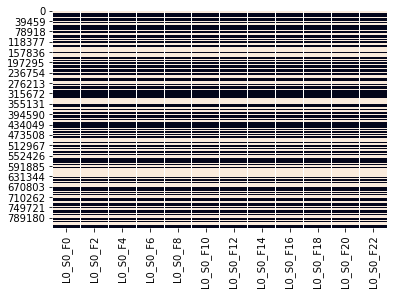

In [67]:
sns.heatmap(train_numeric[cols_S0].isnull(), cbar=False) # checking out the amount of missing data

In [70]:
train_numeric[cols_S0].isnull().sum() / len(train_numeric[cols_S0]) # get the exact percentage of missing data in columns

L0_S0_F0     0.431036
L0_S0_F2     0.431036
L0_S0_F4     0.431036
L0_S0_F6     0.431036
L0_S0_F8     0.431036
L0_S0_F10    0.431036
L0_S0_F12    0.431036
L0_S0_F14    0.431036
L0_S0_F16    0.431036
L0_S0_F18    0.431036
L0_S0_F20    0.431036
L0_S0_F22    0.431036
dtype: float64

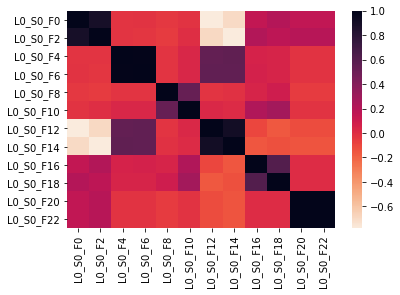

In [66]:
sns.heatmap(train_numeric[cols_S0].corr(), cmap=sns.cm.rocket_r) # checking the correlation between variables

While some features were distributed normally, there were some anomalies.

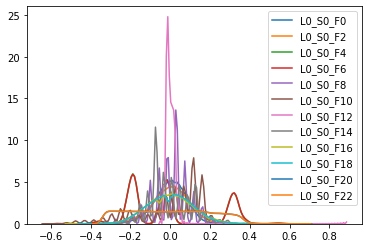

In [59]:
for col in cols_S0:
  sns.kdeplot(train_numeric[col]) # checking the distribution of the variables

### Preprocessing
After some exhausting work loading in and exploring the data, I concatenated the data into our desired format for further modeling.

In [0]:
train_data = pd.concat([train_numeric.iloc[:,:-1], train_date], axis=1)
train_target = train_numeric.Response.to_numpy()
test_data = pd.concat([test_numeric, test_date], axis=1)

Before moving on to the next step, we'll need to deal with the missing data first. I assumed that most of the missing data does not have any implied meaning, that is, each product (ID) only went through a unique set of stations. If the data is missing from one feature, it simply meant that the product didn't go through that station. Hence, I felt like filling the missing data with 0s was the way to go. 
From the exploration, I also noticed that the data is quite inbalanced. Therefore, I standardized the variables to the same scale.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data.iloc[:,1:].fillna(0)) # fill NA values with 0
scaled_test_data = scaler.fit_transform(test_data.iloc[:,1:].fillna(0))

In [17]:
print(scaled_train_data.shape)
print(scaled_test_data.shape)

(828623, 1020)
(358489, 1020)


## Constructing the Model
1. Create custom metric (Matthews Correlation Coefficient)
2. Create a modeling function to make cross validation easier.
3. Prepare model for cross validation (4 folds).
4. Fit model and evaluate accuracy / loss to choose best epoch / batch size.

### Creating Custom Metric
keras.metrics.matthews_correlation was deprecated as of Jan. 2019 (please correct me if I'm mistaken), therefore I decided to create a custom metric for MCC to fit the scoring criteria in Kaggle. 

> MCC formula: (TP × TN) - (FP × FN) / ((TP + FP)(TP + FN)(TN + FP)(TN + FN)) ^ 1 / 2  
> (TP: true positive, FP: false positive, TN: true negative, FN: false negative)

Reference: [Creating custom metrics (MCC)](https://stackoverflow.com/questions/56865344/how-do-i-calculate-the-matthews-correlation-coefficient-in-tensorflow); [Matthews Correlation with Keras](https://stackoverflow.com/questions/39895742/matthews-correlation-coefficient-with-keras)

In [19]:
import keras.backend as K

# y_true: target values
# y_pred: predicted probabilities from model
def matthews_correlation(y_true, y_pred):
    # y_pos → 1, y_neg → 0
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    # y_pred_pos (y_pred > 0.5) → 1, y_pred_neg → 0  
    y_pred_pos = K.round(K.clip(y_pred, 0, 1)) 
    y_pred_neg = 1 - y_pred_pos 

    # tp: number of 1s in "y_pos * y_pred_pos" array, which implies "true and correct" predictions; same logic applies to the rest 
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    # use function to calculate MCC
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

Using TensorFlow backend.


### Creating Function for Modeling

In [0]:
from keras import models
from keras.layers import Dense
from keras import losses
from keras import optimizers
from keras import metrics

def build_model():
    model = models.Sequential()
    model.add(Dense(64, activation="relu", input_shape=(scaled_train_data.shape[1],)))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    
    # assigning optimizer, loss function, and evaluation metric
    model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                  loss=losses.binary_crossentropy,
                  metrics=[matthews_correlation]) # using custom MCC metric to calculate accuracy
    return model

### Cross Validation & Model Fitting

In [22]:
from sklearn.model_selection import StratifiedKFold

# hyperparameters
epochs = 50
batch_size = 512

# splitting the data into 4 folds for cross validation 
kfold = StratifiedKFold(n_splits=4)
all_history = []

# fitting model & cross validation
for index, (train, val) in enumerate(kfold.split(scaled_train_data, train_target)):
    print("Fold #", index+1)
    model = build_model() # calling model function
    history = model.fit(scaled_train_data[train],
                        train_target[train],
                        validation_data=(scaled_train_data[val], train_target[val]),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)
    mcc_history = history.history['val_matthews_correlation']
    all_history.append(mcc_history) # obtaining validation accuracy (MCC)

print(all_history)

# used to optimize number of epochs
average_mcc_history = [np.mean([x[i] for x in all_history]) for i in range(epochs)]

Fold # 1
Train on 621467 samples, validate on 207156 samples
Epoch 1/50
621467/621467 [==============================] - 7s 12us/step - loss: 0.0396 - matthews_correlation: 0.0238 - val_loss: 0.0358 - val_matthews_correlation: 0.0371
Epoch 2/50
621467/621467 [==============================] - 7s 12us/step - loss: 0.0352 - matthews_correlation: 0.0477 - val_loss: 0.0356 - val_matthews_correlation: 0.0474
Epoch 3/50
621467/621467 [==============================] - 7s 12us/step - loss: 0.0346 - matthews_correlation: 0.0603 - val_loss: 0.0357 - val_matthews_correlation: 0.0551
Epoch 4/50
621467/621467 [==============================] - 7s 12us/step - loss: 0.0343 - matthews_correlation: 0.0753 - val_loss: 0.0357 - val_matthews_correlation: 0.0734
Epoch 5/50
621467/621467 [==============================] - 7s 12us/step - loss: 0.0341 - matthews_correlation: 0.0677 - val_loss: 0.0348 - val_matthews_correlation: 0.0498
Epoch 6/50
621467/621467 [==============================] - 7s 12us/step -

### Evaluating Model Performance

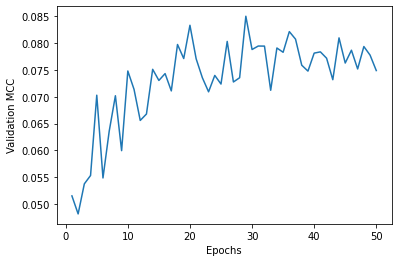

In [23]:
import matplotlib.pyplot as plt

# plotting the model's performance based on number of epochs
plt.plot(range(1, len(average_mcc_history) + 1), average_mcc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MCC')
plt.show()

After examining the results and the plot above, 28 epochs seemed like the way to go! The final model and evaluation plots are down below.

In [24]:
model = build_model() # calling model function
history = model.fit(scaled_train_data,
                        train_target,
                        epochs=28,
                        batch_size=512,
                        verbose=1)

history_dict = history.history

Epoch 1/28
828623/828623 [==============================] - 32s 39us/step - loss: 0.0381 - matthews_correlation: 0.0267
Epoch 2/28
828623/828623 [==============================] - 31s 37us/step - loss: 0.0351 - matthews_correlation: 0.0492
Epoch 3/28
828623/828623 [==============================] - 32s 38us/step - loss: 0.0346 - matthews_correlation: 0.0677
Epoch 4/28
828623/828623 [==============================] - 32s 38us/step - loss: 0.0343 - matthews_correlation: 0.0692
Epoch 5/28
828623/828623 [==============================] - 32s 39us/step - loss: 0.0341 - matthews_correlation: 0.0732
Epoch 6/28
828623/828623 [==============================] - 32s 38us/step - loss: 0.0342 - matthews_correlation: 0.0691
Epoch 7/28
828623/828623 [==============================] - 32s 38us/step - loss: 0.0342 - matthews_correlation: 0.0716
Epoch 8/28
828623/828623 [==============================] - 31s 37us/step - loss: 0.0342 - matthews_correlation: 0.0696
Epoch 9/28
828623/828623 [==============

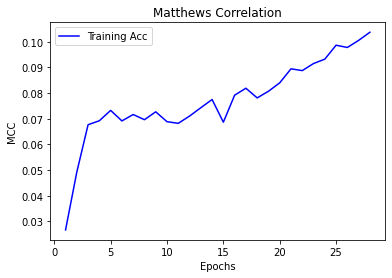

In [25]:
# plotting the training accuracy of keras model
acc = history_dict['matthews_correlation']

epochs = range(1, len(history_dict['matthews_correlation']) + 1)

plt.plot(epochs, acc, color='b', label='Training Acc')
plt.title('Matthews Correlation')
plt.xlabel('Epochs')
plt.ylabel('MCC')
plt.legend()
plt.show()

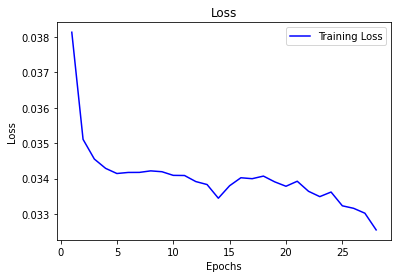

In [26]:
# plotting the training loss/validation loss of keras model
loss = history_dict['loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, loss, color='b', label='Training Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predictions & Output
At long last, we can produce our predictions using the model. Because the output is in a percentage format, we'll need to transform it into 0s and 1s using 0.5 as the threshold.

In [0]:
# fitting the testing dataset to the model to produce predictions
predictions = model.predict(scaled_test_data)

# transforming model outputs into 0s and 1s
test_target = np.where(predictions>0.5, "TRUE", "FALSE")

In [0]:
# exporting dataframe into csv format
submit = pd.DataFrame({'ID':test_data.iloc[:,0].astype(int), 'Response':np.ndarray.flatten(test_target)})
submit.to_csv('submit.csv', index = False)

In [0]:
from google.colab import files
files.download('submit.csv')